tensor(0.3607, grad_fn=<MeanBackward0>)
Ini A0:


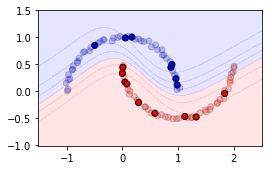

Ini A1:


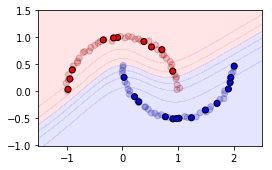

[1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 1 0]
Initial A0:


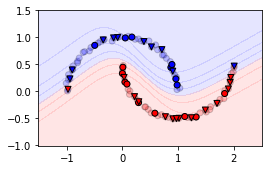

[1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1]
Initial A1:


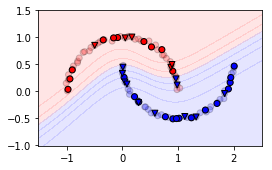

Iteration == 0, Action a0:
Iteration == 0, Action a1:


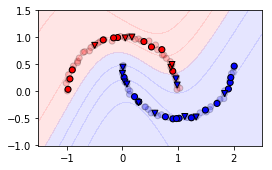

Iteration == 1, Action a0:
Iteration == 1, Action a1:


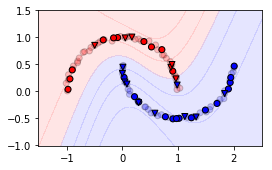

Iteration == 2, Action a0:
Iteration == 2, Action a1:


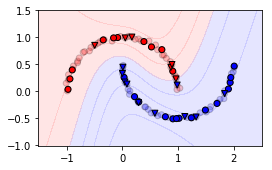

Iteration == 3, Action a0:
Iteration == 3, Action a1:


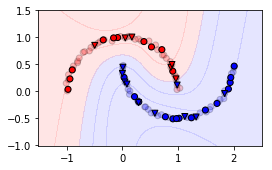

Iteration == 4, Action a0:
Iteration == 4, Action a1:


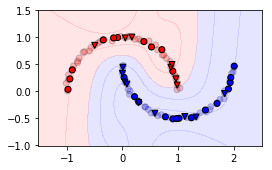

Iteration == 5, Action a0:
Iteration == 5, Action a1:


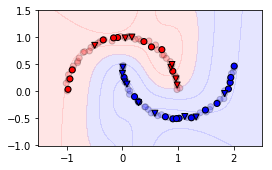

Iteration == 6, Action a0:
Iteration == 6, Action a1:


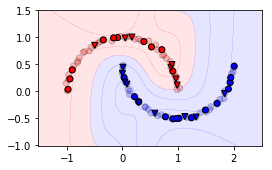

Iteration == 7, Action a0:
Iteration == 7, Action a1:


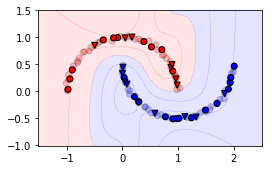

Iteration == 8, Action a0:
Iteration == 8, Action a1:


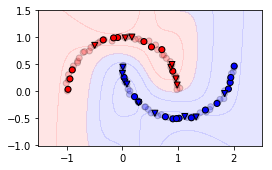

Iteration == 9, Action a0:
Iteration == 9, Action a1:


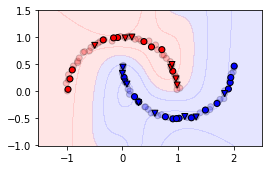

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import random
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import torch
from utils_crm import *
from model_net import * 
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable

seed = 81

h = .02  # step size in the mesh

def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


set_seed(seed)

def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

cm_bright = ListedColormap(['#FF0000', '#0000FF'])

clf = SVC(gamma=2, C=1,probability=True)

clf = MLPClassifier(alpha=1, max_iter=1000)
cm = ListedColormap(['red', 'blue'])
rng = np.random.RandomState(2)
#X += 2 * rng.uniform(size=X.shape)

# for same x
# x | a = 0
X1, y1 = make_moons(noise=0.02, random_state=0)

# x | a = 1
X2, y2 = make_moons(noise=0.02, random_state=0) 

y1 = 1-y1
y2 = 1-y2
#X2 = rotate(X2, origin = (0.5,0.5),degrees = 180)
y2 = 1 - y2
#X = StandardScaler().fit_transform(X)


x_min, x_max = min(X1[:, 0].min(), X2[:, 0].min()) - .5, max(X1[:, 0].max(),X2[:, 0].max()) + .5
y_min, y_max = min(X1[:, 1].min(), X2[:, 1].min()) - .5, max(X1[:, 1].max(),X2[:, 1].max()) + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


X = X1

# logging policy 
# if x0 small select 0 if x1 large select 1 

#a = np.append(np.zeros_like(y1),np.ones_like(y2))
from scipy.special import softmax 
a = np.array([np.random.choice([0,1]) for i in range(X.shape[0])])
y = np.array([i if k ==0 else j for i,j,k in zip(y1,y2,a)])

index = np.array(range(40))
index1 = np.array([i for i,j in zip(index, a[index]) if j==0])
index2 = np.array([i for i,j in zip(index, a[index]) if j==1])

clf = VisNet(2, 2, hidden = 16)
if torch.cuda.is_available():
    inputx = torch.from_numpy(X[index]).cuda()
    targety = torch.from_numpy(y[index]).cuda()
    action = torch.from_numpy(a[index]).long().cuda()
    clf.cuda()
else:
    inputx = torch.from_numpy(X[index])
    targety = torch.from_numpy(y[index])
    action = torch.from_numpy(a[index]).long()
for epoch in range(2000):
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr = 1e-2, weight_decay = 1e-3)

    out = clf(inputx.float())
    out = out[range(out.size(0)), action]
    loss = criterion(out.reshape(-1), targety.float().reshape(-1))
    # backward
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()
print(loss.mean())

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
clf.eval()
grid_input = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()])
Z1 = torch.sigmoid(clf(grid_input.float()))[range(grid_input.shape[0]),torch.zeros(grid_input.shape[0]).long()].detach().numpy()
Z2 = torch.sigmoid(clf(grid_input.float()))[range(grid_input.shape[0]),torch.ones(grid_input.shape[0]).long()].detach().numpy()
clf.train()
# Put the result into a color plot
Z1 = Z1.reshape(xx.shape)
Z2 = Z2.reshape(xx.shape)
plt.figure(figsize=(4,2.5))
plt.contourf(xx, yy, Z1, cmap=cm_bright, alpha=.1)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap=cm, alpha = 0.2,
           edgecolors='k')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())    

plt.scatter(X1[index1,0],X1[index1,1],c=y1[index1],cmap=cm_bright,
           edgecolors='k')

print('Ini A0:')
plt.show()
plt.close()
plt.figure(figsize=(4,2.5))
plt.contourf(xx, yy, Z2, cmap=cm, alpha=.1)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, cmap=cm_bright, alpha = 0.2,
           edgecolors='k')
index2 = index2 
plt.scatter(X2[index2,0],X2[index2,1],c=y2[index2],cmap=cm_bright,
           edgecolors='k')
print('Ini A1:')
plt.show()
plt.close()


# impute first-pseudo labels 
grid_input = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()])
clf.eval()

a_imputed = 1 - action
y_imputed = torch.sigmoid(clf(inputx.float())[range(inputx.size(0)), a_imputed]).detach()
out = y_imputed
y_imputed = torch.where(out <= 0.5, torch.zeros_like(out), torch.ones_like(out))
Z1 = torch.sigmoid(clf(grid_input.float()))[range(grid_input.shape[0]),torch.zeros(grid_input.shape[0]).long()].detach().numpy()
Z2 = torch.sigmoid(clf(grid_input.float()))[range(grid_input.shape[0]),torch.ones(grid_input.shape[0]).long()].detach().numpy()

# Put the result into a color plot
Z1 = Z1.reshape(xx.shape)
Z2 = Z2.reshape(xx.shape)
plt.figure(figsize=(4,2.5))
plt.contourf(xx, yy, Z1, cmap=cm_bright, alpha=.1)


y1_imp = np.array([int(j) if i==0 else int(k) for i,j,k in zip(a[index],y1[index],y_imputed.numpy())])
y2_imp = np.array([int(j) if i==1 else int(k) for i,j,k in zip(a[index],y2[index],y_imputed.numpy())])
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap=cm, alpha = 0.2,
           edgecolors='k')

# pick 6 points 
# remove index1 from index 
index1_rm = np.setdiff1d(index, index1)
plt.scatter(X1[index1,0],X1[index1,1],c=y1_imp[index1],cmap=cm_bright,
           edgecolors='k')
print(y1_imp[index1_rm])
plt.scatter(X1[index1_rm,0],X1[index1_rm,1],c=y1_imp[index1_rm],cmap=cm_bright,
           edgecolors='k', marker = 'v')
print('Initial A0:')
plt.show()
plt.close()

plt.figure(figsize=(4,2.5))
plt.contourf(xx, yy, Z2, cmap=cm, alpha=.1)
plt.scatter(X2[:, 0], X2[:, 1], c=y2, cmap=cm_bright, alpha = 0.2,
           edgecolors='k')
index2_rm = np.setdiff1d(index, index2)
plt.scatter(X2[index2,0],X2[index2,1],c=y2_imp[index2],cmap=cm_bright,
           edgecolors='k')
print(y2_imp[index2_rm])
plt.scatter(X2[index2_rm,0],X2[index2_rm,1],c=y2_imp[index2_rm],cmap=cm_bright,
           edgecolors='k', marker = 'v')

print('Initial A1:')
plt.show()
plt.close()
clf.train()



import contextlib
import torch.nn as nn

@contextlib.contextmanager
def _disable_tracking_bn_stats(model):

    def switch_attr(m):
        if hasattr(m, 'track_running_stats'):
            m.track_running_stats ^= True

    model.apply(switch_attr)
    yield
    model.apply(switch_attr)


def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-8
    return d



class VATLoss(nn.Module):

    def __init__(self, xi=10.0, eps=1.0, ip=1):
        """VAT loss
        :param xi: hyperparameter of VAT (default: 10.0)
        :param eps: hyperparameter of VAT (default: 1.0)
        :param ip: iteration times of computing adv noise (default: 1)
        """
        super(VATLoss, self).__init__()
        self.xi = xi
        self.eps = eps
        self.ip = ip

    def forward(self, model, x, treatment):
        with torch.no_grad():
            pred = model(x)
            pred = torch.sigmoid(pred)

        # prepare random unit tensor
        d = torch.rand(x.shape).sub(0.5).to(x.device)
        d = _l2_normalize(d)

        with _disable_tracking_bn_stats(model):
            # calc adversarial direction
            for _ in range(self.ip):
                d.requires_grad_()
                pred_hat = model(x + self.xi * d)
                pred_hat = torch.sigmoid(pred_hat)
                adv_distance = (1-pred) * torch.log((1-pred)/(1-pred_hat+1e-7)+1e-7) + (pred) * torch.log((pred)/(pred_hat+1e-7)+1e-7)
                mask = torch.ones_like(pred_hat).scatter_(1, treatment.long().unsqueeze(1), 0)
                adv_distance = adv_distance[mask.bool()].reshape(-1).mean()

                adv_distance.backward()
                d = _l2_normalize(d.grad)
                model.zero_grad()
            # calc LDS
            r_adv = d * self.eps
            pred_hat = model(x + r_adv)
            pred_hat = torch.sigmoid(pred_hat)
            lds = (1-pred) * torch.log((1-pred)/(1-pred_hat+1e-7)+1e-7) + (pred) * torch.log((pred)/(pred_hat+1e-7)+1e-7)
            lds = lds[mask.bool()].mean()
        return lds

# self-train
# impute labels 
import copy 
iteration = 10
pseudo_labeler = copy.deepcopy(clf)
for it in range(iteration):
    pseudo_labeler.eval()
    #pseudo_labeler.train()
    vat_loss = VATLoss(xi=10.0, eps=1.0, ip=1)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(clf.parameters(), lr = 1e-3)    
    y_imputed = torch.sigmoid(pseudo_labeler(inputx.float())[range(inputx.size(0)), a_imputed]).detach()
    out = y_imputed 
    y_imputed = torch.where(out <= 0.5, torch.zeros_like(out), torch.ones_like(out))
    for epoch in range(1000):
        a_imputed = 1 - action
        inputx_imp = inputx
        action_imp = a_imputed
        targety_imp = y_imputed


        out = clf(inputx.float())
        out1 = out[range(out.size(0)), action]
        loss1 = criterion(out1.reshape(-1), targety.float().reshape(-1))

        out2 = out[range(out.size(0)), action_imp]
        loss = criterion(out2.reshape(-1), targety_imp.float().reshape(-1))
        # backward
        vatloss = vat_loss(clf, inputx.float(), action)
        loss = (loss + loss1) + 1 * vatloss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch == 999:
            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh [x_min, x_max]x[y_min, y_max].
            grid_input = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()])
            clf.eval()

            a_imputed = 1 - action
            y_imputed = torch.sigmoid(pseudo_labeler(inputx.float())[range(inputx.size(0)), a_imputed]).detach()
            out = y_imputed
            y_imputed = torch.where(out <= 0.5, torch.zeros_like(out), torch.ones_like(out))
            Z1 = torch.sigmoid(clf(grid_input.float()))[range(grid_input.shape[0]),torch.zeros(grid_input.shape[0]).long()].detach().numpy()
            Z2 = torch.sigmoid(clf(grid_input.float()))[range(grid_input.shape[0]),torch.ones(grid_input.shape[0]).long()].detach().numpy()

            # Put the result into a color plot
            Z1 = Z1.reshape(xx.shape)
            Z2 = Z2.reshape(xx.shape)
            plt.figure(figsize=(4,2.5))
            plt.contourf(xx, yy, Z1, cmap=cm_bright, alpha=.1)


            y1_imp = np.array([int(j) if i==0 else int(k) for i,j,k in zip(a[index],y1[index],y_imputed.numpy())])
            y2_imp = np.array([int(j) if i==1 else int(k) for i,j,k in zip(a[index],y2[index],y_imputed.numpy())])
            plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap=cm, alpha = 0.2,
                       edgecolors='k')

            # pick 6 points 
            index1_rm = np.setdiff1d(index, index1)
            plt.scatter(X1[index1,0],X1[index1,1],c=y1_imp[index1],cmap=cm_bright,
                       edgecolors='k')
            plt.scatter(X1[index1_rm,0],X1[index1_rm,1],c=y1_imp[index1_rm],cmap=cm_bright,
                       edgecolors='k', marker = 'v')
            print(f'Iteration == {it}, Action a0:')
            plt.close()
            
            plt.figure(figsize=(4,2.5))
            plt.contourf(xx, yy, Z2, cmap=cm, alpha=.1)
            plt.scatter(X2[:, 0], X2[:, 1], c=y2, cmap=cm_bright, alpha = 0.2,
                       edgecolors='k')
            index2_rm = np.setdiff1d(index, index2)
            plt.scatter(X2[index2,0],X2[index2,1],c=y2_imp[index2],cmap=cm_bright,
                       edgecolors='k')
            plt.scatter(X2[index2_rm,0],X2[index2_rm,1],c=y2_imp[index2_rm],cmap=cm_bright,
                       edgecolors='k', marker = 'v')
            print(f'Iteration == {it}, Action a1:')
            plt.show()
            plt.close()
            clf.train()
            
    pseudo_labeler = copy.deepcopy(clf)
